<a href="https://colab.research.google.com/github/roryrod40/ProSign/blob/master/ProSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note: In order to play game you must the download zipped ProSignFiles folder and upload in to Google Colab Notebook

You can find files here: https://github.com/roryrod40/ProSign/blob/master/ProSignFiles.zip

In [12]:
# Import Statements
import zipfile as zf
from IPython.display import Image as Img, display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np
import random
import time

In [14]:
files = zf.ZipFile("ProSignFiles.zip", 'r')
files.extractall('UnzippedFiles')
files.close()

In [19]:
# Camera Function

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [16]:
# Model Setup

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the models
alphabet_model = load_model("/content/UnzippedFiles/ProSignFiles/alphabet2_model.h5", compile=False)
thumbs_up_model = load_model("/content/drive/MyDrive/TeachableMachineModels/thumbs_up_model.h5", compile=False)

# Load the labels
alphabet_class_names = open("/content/UnzippedFiles/ProSignFiles/alphabet2_labels.txt", "r").readlines()
thumbs_up_class_names = open("/content/drive/MyDrive/TeachableMachineModels/thumbs_up_labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras models
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
alphabet_data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
thumbs_up_data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

In [17]:
# Load Image Function
def load_image(filename='photo.jpg'):
  try:
      file = take_photo(filename)
      # print('Saved to {}'.format(file))

      # Show the image which was just taken.
      display(Image(file))
  except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      error = str(err)
      # print(error)

  # Replace this with the path to your image
  image = Image.open(filename).convert("RGB")

  # resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

  # turn the image into a numpy array
  image_array = np.asarray(image)

  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

  # return image
  return normalized_image_array


In [22]:
# Prediction + Print Results Function
def predict(model, data, class_names):
  # Predicts the model
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  # Print prediction and confidence score
  # print("Class:", class_name, end="")
  # print("Confidence Score:", confidence_score)
  # print(prediction)

  # return index of predicted class
  return index

In [21]:
# Slow Print Function
def slow_print(str, rate = 0):
  for letter in str:
    print(letter, end="")
    time.sleep(rate)


Welcome to the sign language quiz
Enter the number of questions: 100
Please enter a valid number
Question number must be between 1 and 24 inclusive
Enter the number of questions: -1
Please enter a valid number
Question number must be between 1 and 24 inclusive
Enter the number of questions: 13lfdkj
Please enter a valid number
Question number must be between 1 and 24 inclusive
Enter the number of questions: 2
For best results take a picture of only your hand on a neutral background!
Sign the letter M


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 36ms/step
Correct!
Sign the letter S


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 34ms/step
Correct!
Score: 2/2
Highscore: 2
Give a thumbs up to keep playing!


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 35ms/step
Sign the letter Y


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 65ms/step
Incorrect :(
You signed the letter  L
Here is how you sign the letter Y

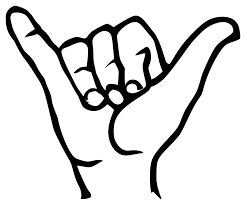

Sign the letter U


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 37ms/step
Incorrect :(
You signed the letter G
Here is how you sign the letter U

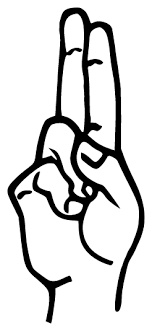

Score: 0/2
Highscore: 2
Give a thumbs up to keep playing!


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 36ms/step
Sign the letter B


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 60ms/step
Correct!
Sign the letter O


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 64ms/step
Correct!
Score: 2/2
Highscore: 2
Give a thumbs up to keep playing!


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 37ms/step
Thanks for playing!
Unfortunately this program cannot test the letters J and Z at this time
Here is how you sign those letters respctively :)


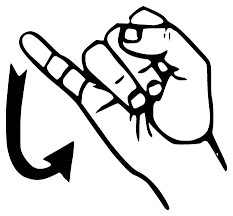

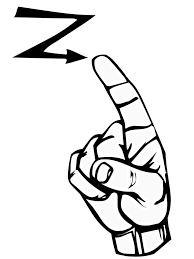

In [24]:
# Quiz Logic

# Useful vairables for game
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
best_score = 0
questions = 5

# Get input for number of games to play
slow_print("Welcome to the sign language quiz\n")
valid_input = False
while not valid_input:
  slow_print("Enter the number of questions: ")
  questions = input("")
  if questions.isnumeric() and int(questions) > 0 and int(questions) < 25:
    valid_input = True
  else:
    slow_print("Please enter a valid number\n")
    slow_print("Question number must be between 1 and 24 inclusive\n")

# Print tips for play
slow_print("For best results take a picture of only your hand on a neutral background!\n")

# Loop quiz through while playing
playing = True
while playing:

  # Useful quiz variables
  current_score = 0
  letters_str = "ABCDEFGHIKLMNOPQRSTUVWXY"

  # Loop through for all questions
  for i in range(int(questions)):

    # Find letter and index
    rand_index = random.randint(0, len(letters_str) - 1)
    letter = letters_str[rand_index]
    letters_str = letters_str[:rand_index] + letters_str[rand_index + 1:]
    letter_index = letters.index(letter)


    # Load the image into the array
    slow_print("Sign the letter " + letter + "\n")
    alphabet_data[0] = load_image("alphabet.jpg")

    # Predict user input
    player_index = predict(alphabet_model, alphabet_data, alphabet_class_names)

    # Check user input
    if(player_index == letter_index):
      slow_print("Correct!\n")
      current_score += 1
    else:
      slow_print("Incorrect :(\n")
      slow_print("You signed the letter " + alphabet_class_names[player_index][2:-1] + "\n")
      slow_print("Here is how you sign the letter " + letter)
      display(Img(filename="/content/UnzippedFiles/ProSignFiles/sign" + str(rand_index+1) +".png"))


  # Update best score
  best_score = max(best_score, current_score)

  # Print scores
  slow_print("Score: " + str(current_score) + "/" + str(int(questions)) + "\n")
  slow_print("Highscore: " + str(best_score) + "\n")

  slow_print("Give a thumbs up to keep playing!\n")

  # Load the image into the array
  thumbs_up_data[0] = load_image("thumbs_up.jpg")

  # Predict user input
  thumbs_up = predict(thumbs_up_model, thumbs_up_data, thumbs_up_class_names) == 0
  if(not thumbs_up):
    playing = False

slow_print("Thanks for playing!\n")
slow_print("Unfortunately this program cannot test the letters J and Z at this time\n")
slow_print("Here is how you sign those letters respctively :)\n")
display(Img(filename="/content/UnzippedFiles/ProSignFiles/letterJ.png"))
display(Img(filename="/content/UnzippedFiles/ProSignFiles/letterZ.png"))

